# Machine leanrning application for ''landslide'' tweets classification.
The ML part is a simple tweet classification exercise to predict label of tweets by models trained with a pre-label data.

There are 236 tweets in total. 156 are labelled ''2'', which are tweets that are not related to
landslide events. 80 tweets are labelled ''1'' and are tweets related to a landslide events.

**Step 1: Load all the required libraies**

In [1]:
import pandas as pd 
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

# sklearn ML libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

# sklearn evaluation metrics
from sklearn.metrics import f1_score

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Data exploration

In [2]:
#
# Read data and check dimension
#
data = pd.read_csv("final_ml.csv")
data.shape

(236, 3)

In [ ]:
#
# check distribution of the labels
#
data.label.value_counts()

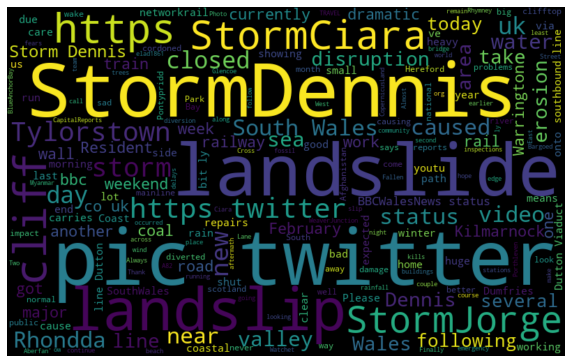

In [46]:
#
# create wordcloud of tweets with label = 1
#
from wordcloud import WordCloud
label_1 = ' '.join([text for text in data['tweet']
                        [data['label']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(label_1)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

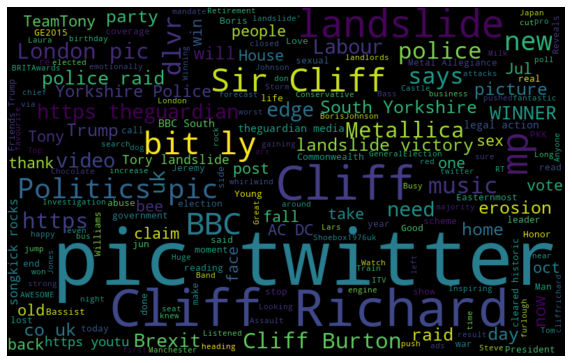

In [47]:
#
# create wordcloud of tweets with label = 2
#
label_2 = ' '.join([text for text in data['tweet']
                        [data['label']==2]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(label_2)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Step 2: Data cleaning**
    
The data is cleaned to make it compatible for the ML algorithm. Characters and special symbols are removed, convert to lower case, t
okenized the tweet, and create the lemma of each token

In [3]:
#
# Load libraries required for preprocessing
#
corpus  = []
#
# initialize nltk lemmatizer
#
lemm = WordNetLemmatizer()
#
# iterate over each tweet and apply preprocessing steps
#
for i in range(data['tweet'].shape[0]):
    #
    #Remove unwanted words
    #
    tweet = re.sub("[^a-zA-Z]", ' ', data['tweet'][i])
    #
    #Transform words to lowercase and split into token
    #
    tweet = tweet.lower()
    tweet = tweet.split()
    #
    #Remove stopwords then lemmatize
    #
    tweet = [lemm.lemmatize(word) for word in tweet if not word in set(stopwords.words('english'))]
    #
    # join tokens
    #
    tweet = ' '.join(tweet)
    #
    #Append cleaned tweet to corpus
    #
    corpus.append(tweet)

In [8]:
#
# We compare the cleaned tweet with before preprocess
#
# original tweet
#
tweet = data["tweet"].head(10)
#
# preprocess tweet
#
cleantweet = pd.DataFrame(corpus, columns=['after_cleaning']).head(10)
#
# frame both in a dataframe
#
frames = [tweet, cleantweet]
result = pd.concat(frames, axis=1, sort=False)
#result[1:]
result

,tweet,after_cleaning
1,Accuser outrage Sir Cliff Richard accused of a...,accuser outrage sir cliff richard accused atta...
2,Tony Blackburn supports Sir Cliff Richard as h...,tony blackburn support sir cliff richard clear...
3,Paul Gambaccini attacks BBC over handling of p...,paul gambaccini attack bbc handling police rai...
4,Tony Blackburn supports Sir Cliff Richard as h...,tony blackburn support sir cliff richard clear...
5,#StormCiara - Disruption between Kilmarnock an...,stormciara disruption kilmarnock carlisle end ...
6,Watch AC/DC Salute Cliff Williams at Bassist's...,watch ac dc salute cliff williams bassist fina...
7,AC/DC Bassist Cliff Williams Confirms Retireme...,ac dc bassist cliff williams confirms retireme...
8,See Metallica Remember Cliff Burton in 'Back t...,see metallica remember cliff burton back front...
9,AC/DC's Angus Young Talks Brother Malcolm And ...,ac dc angus young talk brother malcolm cliff r...


**Step 2: Feature extraction**
    
We represent the clean tweet in a way the ML algorithm can understand. i.e. we create a new feature from the cleaned tweets. We use Bag-of-words model
which is quite a simple model. It basically represent each token of tweet in terms of the frequency they occur.

In [63]:
#
# So we create a dictionary of token and the frequency of occurence
#
word_dic = {}
for tweet in corpus:
    for word in tweet.split():
        if(word in word_dic.keys()):
            word_dic[word] += 1
        else:
            word_dic[word] = 1
            
#       
# Convert the dictionary to dataFrame
#
word_dic = pd.DataFrame.from_dict(word_dic,orient='index',columns=['word frequency'])
#
# Sort
# 
word_dic.sort_values(by=['word frequency'], inplace=True, ascending=False)
#
# Visualize
#
word_dic.head()

,word frequency
com,228
twitter,215
pic,202
cliff,138
http,112


In [64]:
#
# Extract only those with >10 frequency, less frequent word may not make add value in the training
#
word_dic = word_dic[word_dic['word frequency'] >= 10]
#
# What do we have now
#
print(word_dic.shape)
word_dic.head()

(39, 1)


,word frequency
com,228
twitter,215
pic,202
cliff,138
http,112


FInally we now have to create a vector from the token, i.e. transform the text into numbers, Sklearn CountVectorizer is used, 
and this basically use the frequency of occurence to build a bow sparse matrix

In [65]:
#
# Create the transform
#
counVec = CountVectorizer(max_features = word_dic.shape[0])
#
# Build the bow matrix
#
bagOfWords = counVec.fit_transform(corpus).toarray()

**Step 3: Model assessment**
    
Split data into train and test before training the model 

In [66]:
#
# split data into train and test set
#
X = bagOfWords
y = data['label']
print("X shape = ",X.shape)
print("y shape = ",y.shape)

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.25, random_state=11, shuffle =True)

X shape =  (236, 39)
y shape =  (236,)


**Step 4: Build and train ML model on train data**

In [67]:
#
# 5.1 Decision Tree Model
#
decisionTreeModel = DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = None, 
                                           splitter='best', 
                                           random_state=11)

decisionTreeModel.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=11)

In [68]:
#
# 5.2 Gradient Boosting Model
#
gradientBoostingModel = GradientBoostingClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 100,
                                                   max_depth = 30,
                                                   random_state=11)

gradientBoostingModel.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=30, random_state=11)

In [69]:
#
# 5.3 K-Nearesr Meighbours Model
#
KNeighborsModel = KNeighborsClassifier(n_neighbors = 7,
                                       weights = 'distance',
                                      algorithm = 'brute')

KNeighborsModel.fit(X_train,y_train)

KNeighborsClassifier(algorithm='brute', n_neighbors=7, weights='distance')

In [70]:
#
# 5.4 Logistic Regression Model
#
LogisticRegression = LogisticRegression(penalty='l2',
solver='saga',
random_state = 11)
LogisticRegression.fit(X_train,y_train)
print("LogisticRegression Classifier model run successfully")

LogisticRegression Classifier model run successfully


In [71]:
#
# 5.5 Stochastic Grasient Descent Model
#
SGDClassifier = SGDClassifier(loss = 'hinge', 
                              penalty = 'l1',
                              learning_rate = 'optimal',
                              random_state = 11, 
                              max_iter=100)

SGDClassifier.fit(X_train,y_train)

SGDClassifier(max_iter=100, penalty='l1', random_state=11)

In [72]:
#
# 5.6 Support Vector Machine model
#
SVClassifier = SVC(kernel= 'linear',
                   degree=3,
                   max_iter=10000,
                   C=2, 
                   random_state = 11)

SVClassifier.fit(X_train,y_train)


SVC(C=2, kernel='linear', max_iter=10000, random_state=11)

**Step 5: Prediction the test data and generate metrics**
    
Finally we predict the label of our test set and check the accuracy of the model on train set, test set and calculate the F1-score

In [73]:
#
# Create a list of all models
#
models = [decisionTreeModel, gradientBoostingModel, KNeighborsModel, LogisticRegression, 
          SGDClassifier, SVClassifier]
# 
# compute train and test score
#
for model in models:
    print(type(model).__name__,' Train Score is   : ' ,model.score(X_train, y_train))
    print(type(model).__name__,' Test Score is    : ' ,model.score(X_test, y_test))
# 
# Predict on the test set  
#
    y_pred = model.predict(X_test)
#
# Compute the F1 score
#
    print(type(model).__name__,' F1 Score is      : ' ,f1_score(y_test,y_pred))
    print('--------------------------------------------------------------------------')

DecisionTreeClassifier  Train Score is   :  0.96045197740113
DecisionTreeClassifier  Test Score is    :  0.9152542372881356
DecisionTreeClassifier  F1 Score is      :  0.8275862068965517
--------------------------------------------------------------------------
GradientBoostingClassifier  Train Score is   :  0.96045197740113
GradientBoostingClassifier  Test Score is    :  0.9322033898305084
GradientBoostingClassifier  F1 Score is      :  0.8571428571428571
--------------------------------------------------------------------------
KNeighborsClassifier  Train Score is   :  0.96045197740113
KNeighborsClassifier  Test Score is    :  0.8983050847457628
KNeighborsClassifier  F1 Score is      :  0.7857142857142857
--------------------------------------------------------------------------
LogisticRegression  Train Score is   :  0.9378531073446328
LogisticRegression  Test Score is    :  0.9491525423728814
LogisticRegression  F1 Score is      :  0.9032258064516129
-------------------------------